# GPU Stencil2d program

In [1]:
import timeit
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

In [2]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))
    
def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file('in_field.dat')
    k_lev = in_field.shape[0] // 2
    im1 = axs[0].imshow(in_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im1, ax=axs[0]);
    axs[0].set_title('Initial condition (k = {})'.format(k_lev));

    out_field = read_field_from_file('out_field.dat')
    k_lev = out_field.shape[0] // 2
    im2 = axs[1].imshow(out_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im2, ax=axs[1]);
    axs[1].set_title('Final result (k = {})'.format(k_lev));
    
    plt.show()

In [6]:
%%bash
echo "====== 128 x 128 x 64 ======"
srun -n 12 ./stencil2d-basic.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_basic.txt

====== 128 x 128 x 64 ======


CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


## OpenACC version 1

This is the first step of implementing the use of the GPU to accelerate the computation.
Only the j and i loops inside the k loop are parallelised using simple !$acc parallel and !$acc loop gang/vector.

I havn't yet tried to transfer the data to avoid overhead

### Compiling

In [20]:
%%bash
module switch PrgEnv-gnu PrgEnv-cray

ftn -O3 -eZ -c m_utils.F90
ftn -O3 -eZ -c stencil2d_openacc_parallel.F90
ftn -O3 -eZ m_utils.o stencil2d_openacc_parallel.o -o stencil2d_openacc_parallel.x

### Running and validating

In [22]:
output = !srun ./stencil2d_openacc_parallel.x --nx 64 --ny 64 --nz 32 --num_iter 1024 #> /dev/null
print(output.nlstr)

pd.DataFrame(columns=['x','y','z','iter','time'],data=[\
[   64,   64,   32,    1028,     0.053], \
] )


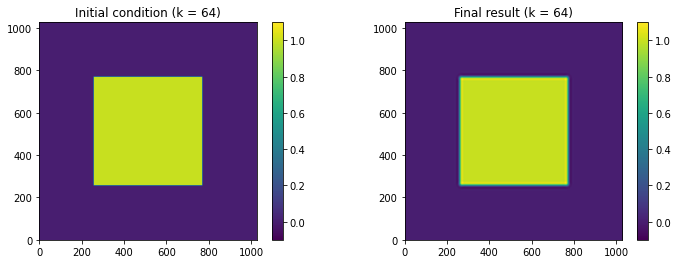

In [9]:
validate_results()

In [24]:
%%bash
srun ./stencil2d_openacc_parallel.x --scan --ny 64 --nz 32 --num_iter 1024 > ./bench_openacc_parallel.txt

### Compiling

In [25]:
%%bash
module switch PrgEnv-gnu PrgEnv-cray

ftn -O3 -eZ -c m_utils.F90
ftn -O3 -eZ -c stencil2d_openacc_v2.F90
ftn -O3 -eZ m_utils.o stencil2d_openacc_v2.o -o stencil2d_openacc_v2.x

In [26]:
output = !srun ./stencil2d_openacc_v2.x --nx 64 --ny 64 --nz 32 --num_iter 1024 #> /dev/null
print(output.nlstr)

pd.DataFrame(columns=['x','y','z','iter','time'],data=[\
[   64,   64,   32,    1024,     0.049], \
] )


In [28]:
%%bash
srun ./stencil2d_openacc_v2.x --scan --ny 64 --nz 32 --num_iter 1024 > ./bench_openacc_v2.txt

srun: interrupt (one more within 1 sec to abort)
srun: StepId=55807539.17 task 0: running


Error while terminating subprocess (pid=9951): 


### Compiling

In [38]:
%%bash
module switch PrgEnv-gnu PrgEnv-cray

ftn -O3 -eZ -c m_utils.F90
ftn -O3 -eZ -c stencil2d_openacc_v3.F90
ftn -O3 -eZ m_utils.o stencil2d_openacc_v3.o -o stencil2d_openacc_v3.x

In [39]:
output = !srun ./stencil2d_openacc_v3.x --nx 64 --ny 64 --nz 32 --num_iter 1024 
print(output.nlstr)

ACC: WARNING: Force free of all reusable memory from stencil2d_openacc_v3.F90:138
ACC: WARNING: Force free of all reusable memory from stencil2d_openacc_v3.F90:138
ACC: craylibs/libcrayacc/acc_hw_nvidia.c:620 CRAY_ACC_ERROR -  cuMemAlloc returned CUDA_ERROR_OUT_OF_MEMORY: 'out of memory' from stencil2d_openacc_v3.F90:138
srun: error: nid02551: task 0: Exited with exit code 1
srun: launch/slurm: _step_signal: Terminating StepId=55807539.20


srun: Job 55807539 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Job 55807539 step creation still disabled, retrying (Requested nodes are busy)
srun: Step created for job 55807539
pd.DataFrame(columns=['x','y','z','iter','time'],data=[\
[   64,   64,   32,    1024,     0.062], \
] )


In [40]:
%%bash
srun ./stencil2d_openacc_v3.x --scan --ny 64 --nz 32 --num_iter 1024 > ./bench_openacc_v3.txt

ACC: WARNING: Force free of all reusable memory from stencil2d_openacc_v3.F90:138
ACC: WARNING: Force free of all reusable memory from stencil2d_openacc_v3.F90:138
ACC: craylibs/libcrayacc/acc_hw_nvidia.c:620 CRAY_ACC_ERROR -  cuMemAlloc returned CUDA_ERROR_OUT_OF_MEMORY: 'out of memory' from stencil2d_openacc_v3.F90:138
srun: error: nid02551: task 0: Exited with exit code 1
srun: launch/slurm: _step_signal: Terminating StepId=55807539.22


CalledProcessError: Command 'b'srun ./stencil2d_openacc_v3.x --scan --ny 64 --nz 32 --num_iter 1024 > ./bench_openacc_v3.txt\n'' returned non-zero exit status 1.

### Compiling

In [50]:
%%bash
module switch PrgEnv-gnu PrgEnv-cray

ftn -O3 -eZ -c m_utils.F90
ftn -O3 -eZ -c stencil2d_openacc_v4.F90
ftn -O3 -eZ m_utils.o stencil2d_openacc_v4.o -o stencil2d_openacc_v4.x

In [56]:
output = !srun ./stencil2d_openacc_v4.x --nx 16 --ny 64 --nz 32 --num_iter 1024 
print(output.nlstr)

pd.DataFrame(columns=['x','y','z','iter','time'],data=[\
[   16,   64,   32,    1024,     0.033], \
] )


In [43]:
%%bash
srun ./stencil2d_openacc_v4.x --scan --ny 64 --nz 32 --num_iter 1024 > ./bench_openacc_v4.txt

ACC: WARNING: Force free of all reusable memory from stencil2d_openacc_v4.F90:138
ACC: craylibs/libcrayacc/acc_hw_nvidia.c:620 CRAY_ACC_ERROR -  cuMemAlloc returned CUDA_ERROR_OUT_OF_MEMORY: 'out of memory' from stencil2d_openacc_v4.F90:138
srun: error: nid02551: task 0: Exited with exit code 1
srun: launch/slurm: _step_signal: Terminating StepId=55807539.24


CalledProcessError: Command 'b'srun ./stencil2d_openacc_v4.x --scan --ny 64 --nz 32 --num_iter 1024 > ./bench_openacc_v4.txt\n'' returned non-zero exit status 1.

## OpenACC k-parallel version


### Compiling

In [83]:
%%bash
module switch PrgEnv-gnu PrgEnv-cray

ftn -O3 -eZ -c m_utils.F90
ftn -O3 -eZ -c stencil2d_openacc_k.F90
ftn -O3 -eZ m_utils.o stencil2d_openacc_k.o -o stencil2d_openacc_k.x

In [97]:
output = !srun ./stencil2d_openacc_k.x --nx 1024 --ny 1024 --nz 128 --num_iter 4096 
print(output.nlstr)

pd.DataFrame(columns=['x','y','z','iter','time'],data=[\
[ 1024, 1024,  128,    4096,    64.721], \
] )


In [72]:
%%bash
srun ./stencil2d_openacc_k.x --scan --nx 64 --nz 32 --num_iter 1024 > ./bench_openacc_k.txt

slurmstepd: error: Detected 1 oom-kill event(s) in StepId=55807539.47 cgroup. Some of your processes may have been killed by the cgroup out-of-memory handler.
srun: error: nid02551: task 0: Out Of Memory
srun: launch/slurm: _step_signal: Terminating StepId=55807539.47


CalledProcessError: Command 'b'srun ./stencil2d_openacc_v5.x --scan --nx 64 --nz 32 --num_iter 1024 > ./bench_openacc_v5.txt\n'' returned non-zero exit status 1.